# Clustering with News Publications
Author: Matthew Huh
    
## Overview

For the most part, people are free to choose what news outlets they read and follow. In the United States, there is a near-endless list of sites that people can choose from in order to get their daily news and over time, they develop preferences for sites that they are more attached to, and do their best to avoid. Now these affinities are developed through a combination of means ranging from affiliations, vocabulary, prose, and so forth.

What I would like to examine in this project is if it is possible to differentiate from several different publications with their respective perks / quirks. 

## About the Data

This dataset was obtained from Kaggle, and contains a collection of 142,570 articles from 15 different publications.

The publications within this dataset are
1. CNN
2. Breitbart
3. Vox
4. Washington Post
5. New York Post
6. National Review
7. NPR
8. Guardian
9. Talking Points Memo
10. Atlantic
11. Reuters
12. Fox News
13. Business Insider
14. Buzzfeed News
15. New York Times

## Research Question

As this is an unsupervised learning project first and foremost, the project will have 3 goals.

1. The first goal is to prepare the articles in the dataset for modelling using various Natural Language Processing (NLP) methods to re-represent the data in numbers rather than words
2. Cluster the data to determine if we can identify the articles and associate them as different groups.
3. Determine if we can predict the structure of the article based on the publisher.

## Packages

In [1]:
# Basic imports
import os
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning packages
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import normalize
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from scipy.spatial.distance import cdist

# Natural Language processing
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_rcv1

## Data Preview

The first matter of business is to import the articles from a local directory and merge them.

In [2]:
# Create list of files from directory
filelist = os.listdir('articles')

# Import the files
df_list = [pd.read_csv(file) for file in filelist]

#concatenate them together
articles = pd.concat(df_list)

# Preview the data
articles.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [3]:
# Print the size of the dataset
articles.shape

(142570, 10)

So we have 142,570 articles in the dataset but unfortunately, NLP is quite memory intensive, so we will have to sample the dataset unless you happen to have over 120 GB of memory on your local device. Using a 10% sample still leaves us with 140,000 articles and will be used for the duration of this project.

In [4]:
# Sample the dataset for optimal performance
articles = articles.sample(frac=0.1)

In [5]:
# Print out unique publisher names
articles.publication.unique()

array(['Washington Post', 'CNN', 'New York Post', 'Buzzfeed News', 'NPR',
       'Guardian', 'Breitbart', 'Atlantic', 'Business Insider',
       'National Review', 'New York Times', 'Talking Points Memo',
       'Reuters', 'Vox', 'Fox News'], dtype=object)

In [6]:
# Describe unique occurences for each categorical variable
articles.select_dtypes(include=['object']).nunique()

title          14251
publication       15
author          3957
date            1056
url             8605
content        14246
dtype: int64

There are also other ways to trim down the dataset before processing. We aren't particularly interested in examining the dates for this research question, but it may be of interest in another. Let's check to see how many articles each author wrote; it may not be very useful to examine authors that are only responsible for a single article, as different authors from the same publisher may choose compose their works differently.

In [7]:
# Drop variables that have no impact on the outcome
articles = articles[['title', 'publication', 'author', 'content']]

In [8]:
# View most frequently occurring authors
articles.groupby(['author']).size().sort_values(ascending=False)

author
Breitbart News                                                    144
Associated Press                                                  130
Pam Key                                                           120
Charlie Spiering                                                   94
Daniel Nussbaum                                                    86
Jerome Hudson                                                      85
AWR Hawkins                                                        84
John Hayward                                                       74
Warner Todd Huston                                                 66
Joel B. Pollak                                                     63
Camila Domonoske                                                   63
Breitbart London                                                   60
Post Editorial Board                                               56
Ian Hanchett                                                       55
Trent Baker  

Well, that partly explains how there are so many authors in this dataset. It seems as though there are over 15,000 authors, and many of them have only published one article, or have co-written multiple articles with other authors. This complicates the problem, so in order to best represent each author's writing style, let's see what happens if we simply remove all authors that only published one article as is.

In [9]:
# Plotly packages
import plotly as py
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

# Pass in values for our pie chart
trace = go.Pie(labels=articles['publication'].unique(), values = articles['publication'].value_counts())

# Create the layout
layout = go.Layout(
    title = 'Articles by Publication',
    height = 600,
    width = 800,
    autosize = False
)

# Construct the chart
fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig, filename ='cufflinks/simple')

## Feature Selection

In [10]:
# Drop author from the dataframe if they wrote less than 5 articles
vc = articles['author'].value_counts()
u  = [i not in set(vc[vc<=4].index) for i in articles['author']]
articles = articles[u]

In [11]:
# Reprint how many unique authors there are
articles.select_dtypes(include=['object']).nunique()

title          9324
publication      15
author          608
content        9318
dtype: int64

In [12]:
# View number of articles after feature selection
articles.shape

(9326, 4)

So after removing authors that composed fewer than 5 articles, we are left with 9k articles, or 67% of the data, and roughly 600/3900 of the authors. Now, we can create a better representation of each author since each author has at least 5 articles to evaluate from.

## Text Cleaning

Now that we've chosen which articles to use, it's time to clean them up and prepare them for feature engineering. What this section covers is the removal of annoying punctuation from the content, and reducing words to their lemmas to reduce the number of words that we are examining. Finally, we'll divide the articles into training and testing sets and separate our predictor, the words in the content, and the target, the publisher.

In [13]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [14]:
# Remove annoying punctuation from the articles
articles['content'] = articles.content.map(lambda x: text_cleaner(str(x)))
articles.head()

,title,publication,author,content
34296,Lawmakers to Trump: Turn over transcript of me...,Washington Post,Elise Viebeck,A growing number of Republican and Democratic ...
39572,Man charged with attacking Uber driver sues dr...,New York Post,Associated Press,"COSTA MESA, Calif. — A Southern California man..."
5253,Democratic Response To Trump’s Address To Cong...,NPR,NaN,Following President Trump’s address to a joint...
48670,Trump tries to salvage travel ban amid numerou...,Guardian,Ben Jacobs,Donald Trump scrambled to salvage his controve...
32448,"Influential conservative group: Trump, DeVos s...",Washington Post,Emma Brown,A policy manifesto from an influential conserv...


In [15]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for article in articles['content']:
    article = lemmatizer.lemmatize(article)

In [16]:
# Identify predictor and target variables
X = articles['content']
y = articles['publication']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Tf-idf Vectorization

The first types of features that we are going to add are the most useful words in our dataset. Now how are we going to determine which words are deemed the most "useful"? With TF-IDF vectorizer, of course.

TF tracks the term frequency, or how often each word appears in all articles of text, while idf (or Inverse Document Frequency) is a value that places less weight on variables that occur too often and lose their predictive power. Put together, it's a tool that allows us to assign an importance value to each word in the entire dataset based on frequency in each row and throughout the database.

These are the parameters that will be used for TF-IDF
1. All words that appear in over half of the articles will be thrown out of the dataframe
2. Only words that occur more than 5 times will be tracked
3. Only the top 150 features (words) will be kept
4. Stop words will be ignored (like, as, the)
5. Cases will be ignored
6. Shorter and longer articles will be treated equally
7. Add 1 to document frequency in case we have to divide by 0

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=5, 
                             max_features=150, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

Number of features: 150


### Phrase count with spacy

The second set of variables that we will be creating are counters of how often each publishers makes use of each part of speech, meaning adverbs, verbs, nouns, adjectives, as well as article length.

In [18]:
# Instantiating spaCy
nlp = spacy.load('en')
X_train_words = []

for row in X_train:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_train_words.append([row_doc, advs, verb, noun, adj, sent_len])

# Create dataframe with count of adverbs, verbs, nouns, and adjectives
X_count = pd.DataFrame(data=X_train_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Change token count to token percentage
for column in X_count.columns[1:5]:
    X_count[column] = X_count[column] / X_count['sent_length']

# Normalize X_count
X_counter = normalize(X_count.drop('BOW',axis=1))
X_counter  = pd.DataFrame(data=X_counter)

In [19]:
# Combine tf-idf matrix and phrase count matrix
features = pd.concat([X_counter,X_normal], ignore_index=False, axis=1)
features.head()

,0,1,2,3,4,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.000328,0.000705,0.000623,0.000393,0.999999,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.197798,0.0,0.334632,0.00000,0.000000
1,0.000110,0.000327,0.000275,0.000125,1.000000,0.059944,0.062871,0.0,0.048974,0.0,...,0.0,0.000000,0.452318,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000
2,0.000582,0.001136,0.000554,0.000360,0.999999,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000
3,0.000137,0.000630,0.000425,0.000182,1.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000
4,0.000128,0.000548,0.000411,0.000183,1.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.118669,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.05139,0.674409


And now we have our list of features. It doesn't look anything like our original dataset, now does it? That's because our sentences have been transformed into numbers to feed into our clustering algorithms and predictive models.

# Clustering

Now it's finally time for some unsupervised machine learning. Each article has been binarized to 1s and 0s, and it's time to determine if we can determine if each publisher has a different method for publication.

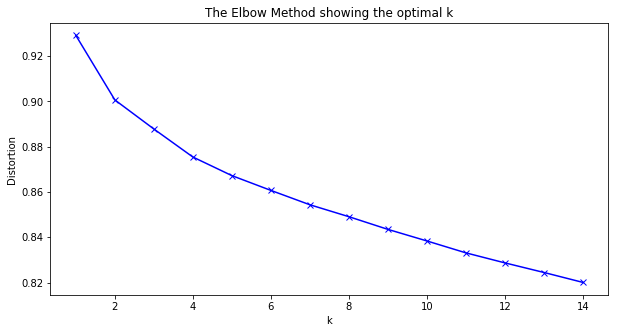

In [20]:
# Size of graph
plt.rcParams['figure.figsize'] = [10,5]

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features)
    kmeanModel.fit(features)
    distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

It seems as though by using the elbow method, the ideal number for k (number of clusters) is 3 as that is when the distortion decreases drop off. That's relatively small compared to the 15 publications that we actually have, but it may be more useful to work with for prediction.

### K-means

The first clustering method I'll use for modelling the dataset is K-means, that requires the user to input k number of centroids, determining the nearest centroid for each data point, and adjusting the centroids until the best clusters are found, or until a set number of iterations has passed. However, we want to see if we can cluster the articles into 15 clusters representing each of the publishers, so that will be k.

In [21]:
# Calulate predicted values
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=20)
y_pred0 = kmeans.fit_predict(features)

pd.crosstab(y_train, y_pred0)

col_0,0,1,2
publication,,,
Atlantic,28,103,287
Breitbart,216,419,1006
Business Insider,23,91,299
Buzzfeed News,3,44,183
CNN,28,124,465
Fox News,52,39,192
Guardian,10,51,176
NPR,29,60,376
National Review,33,88,173


In [22]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred0)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred0, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.004298765
Silhouette Score: 0.04092314


In [23]:
# Calulate predicted values
kmeans = KMeans(n_clusters=15, init='k-means++', random_state=42, n_init=20)
y_pred = kmeans.fit_predict(features)

pd.crosstab(y_train, y_pred)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
publication,,,,,,,,,,,,,,,
Atlantic,13,71,70,5,25,15,12,14,17,8,11,10,110,22,15
Breitbart,76,491,262,64,181,49,115,53,43,15,66,37,120,33,36
Business Insider,16,106,52,7,22,6,7,3,14,4,23,6,80,6,61
Buzzfeed News,7,59,30,1,2,5,31,0,2,2,13,6,31,15,26
CNN,28,178,78,1,23,15,59,0,28,14,34,27,97,24,11
Fox News,6,75,31,9,49,5,36,5,6,2,5,15,20,13,6
Guardian,9,41,32,0,8,4,21,0,5,2,16,12,69,11,7
NPR,14,77,42,2,21,12,18,13,17,105,11,13,89,18,13
National Review,20,51,54,15,25,14,4,9,18,4,6,3,58,11,2


In [24]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.02919908
Silhouette Score: 0.06723925


So based on the two results, it seems as though it's much better to stick to 3 clusters as our silhouette score suffers dramatically if we actually want to cluster all 15 different publications.

### Spectral Clustering

In [25]:
sc = SpectralClustering(n_clusters=3)
y_pred2 = sc.fit_predict(features)

pd.crosstab(y_train, y_pred2)

col_0,0,1,2
publication,,,
Atlantic,297,92,29
Breitbart,1094,335,212
Business Insider,314,75,24
Buzzfeed News,189,39,2
CNN,478,113,26
Fox News,194,36,53
Guardian,181,46,10
NPR,380,55,30
National Review,189,69,36


In [26]:
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred2)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred2, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.003924217
Silhouette Score: 0.03775445


### Affinity Propagation

Now, for our final attempt at clustering, affinity propagation. It's a method that will group like data points, but most likely result in an excessive number of clusters. Let's see if that can work to our advantage.

In [27]:
af = AffinityPropagation()
y_pred3 = af.fit_predict(features)

pd.crosstab(y_train, y_pred3)

col_0,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
publication,,,,,,,,,,,,,,,,,,,,,
Atlantic,2,1,5,7,4,2,1,0,0,0,...,0,1,2,0,0,1,0,0,2,1
Breitbart,8,3,5,18,2,4,6,4,0,3,...,0,1,5,14,1,7,0,0,5,6
Business Insider,0,0,0,2,1,2,4,1,0,0,...,0,0,3,2,0,0,0,1,2,0
Buzzfeed News,1,0,0,1,3,1,1,0,1,0,...,0,0,1,0,0,1,0,0,1,1
CNN,2,0,2,4,1,1,0,0,8,5,...,1,2,2,1,1,3,25,0,1,1
Fox News,0,1,0,2,1,0,0,1,0,1,...,0,2,4,0,0,0,0,0,0,0
Guardian,0,0,1,2,0,0,0,1,0,0,...,0,0,6,0,1,0,0,0,0,1
NPR,3,0,0,1,0,7,0,0,0,1,...,0,1,0,0,9,3,1,8,4,0
National Review,2,2,3,5,0,2,0,0,0,0,...,0,0,0,2,0,4,0,0,4,0


In [28]:
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred3)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred3, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.01145051
Silhouette Score: 0.0110909


And the results are worthless, just pitiful. Seems like k-means is the best clustering algorithm- mostly because our other methods were far worse, not because it performed well.

In [29]:
X_train_cluster = pd.DataFrame(features)
X_train_cluster['kmeans'] = y_pred

# Training the Model

So now that we attempted clustering with the datset, it's time to run the models.

### Random Forest

In [30]:
rfc = ensemble.RandomForestClassifier()
rfc_train = cross_val_score(rfc, features, y_train, cv=5, n_jobs=-1)
print('Random forest classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(rfc_train.mean(), rfc_train.std()*2))

rfc_train_c = cross_val_score(rfc, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Random forest classifier score (with clustering): {:.5f}(+/- {:.2f})'.format(rfc_train_c.mean(), rfc_train_c.std()*2))

Random forest classifier score (without clustering): 0.41634(+/- 0.02)

Random forest classifier score (with clustering): 0.41505(+/- 0.02)


### Logistic Regression

In [31]:
lr = LogisticRegression()
lr_train = cross_val_score(lr, features, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (without clustering): {:.5f}(+/- {:.2f})\n'.format(lr_train.mean(), lr_train.std()*2))

lr_train_c = cross_val_score(lr, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (with clustering): {:.5f}(+/- {:.2f})'.format(lr_train_c.mean(), lr_train_c.std()*2))

Logistic regression score (without clustering): 0.44837(+/- 0.02)

Logistic regression score (with clustering): 0.44837(+/- 0.02)


### Gradient Boosting Classifier

In [32]:
gbc = ensemble.GradientBoostingClassifier()
gbc_train = cross_val_score(gbc, features, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(gbc_train.mean(), gbc_train.std()*2))

gbc_train_c = cross_val_score(gbc, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (with clustering): {:.5f}(+/- {:.2f})'.format(gbc_train_c.mean(), gbc_train_c.std()*2))

Gradient boosting classifier score (without clustering): 0.49597(+/- 0.02)

Gradient boosting classifier score (with clustering): 0.49569(+/- 0.03)


It looks like out of the 3 models, gradient boosting fares the best, and without incorporating clustering at that. Let's see if we can tune our model with better parameters using GridSearchCV.

### Optimized Gradient Boosting Classifier 

In [33]:
# Parameters for gradient boosting classifier
param_grid  = {'loss':['deviance'],
               'max_features': ['sqrt'],
               'n_estimators': [400, 800],
               'max_depth': [12, 20],
               "min_samples_leaf" : [12, 20]}

# Run grid search to find ideal parameters
gbc_grid = GridSearchCV(gbc, param_grid = param_grid, n_jobs=-1)

# Initialize and fit the model.
gbc_grid.fit(features, y_train)

# Return best parameters and best score
print('Best parameters:')
print(gbc_grid.best_params_)
print('Best Score:')
print(gbc_grid.best_score_)

Best parameters:
{'loss': 'deviance', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 400}
Best Score:
0.520017157563626


It's not much of an improvement, but we'll take anything we can at this time. We could attempt to improve the accuracy of our model using larger parameter values, but expanding this model could increase the runtime exponentially.

# Testing the Model

Recall that earlier, we split the data into 2 sets, a training set and a test set. Now, it's time to test the test set and see if the settings from our training model will work with the test set.

In [34]:
# Normalize Tf-idf vectors
X_test_norm = normalize(X_test_tfidf)

In [35]:
X_test_words = []

for row in X_test:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_test_words.append([row_doc, advs, verb, noun, adj, sent_len])
    
# Data frame for features
X_test_count = pd.DataFrame(data=X_test_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Change token count to token percentage
for column in X_test_count.columns[1:5]:
    X_test_count[column] = X_test_count[column] / X_test_count['sent_length']

# Normalize X_count
X_test_counter = normalize(X_test_count.drop('BOW',axis=1))
X_test_counter  = pd.DataFrame(data=X_test_counter)

In [36]:
# Combining features into one data frame
X_test_norm_df = pd.DataFrame(data=X_test_norm.toarray())
features_test = pd.concat([X_test_counter, X_test_norm_df], ignore_index=False, axis=1)
features_test.head()

,0,1,2,3,4,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.000127,0.000465,0.000388,0.000249,1.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.132212,0.143814,0.0,0.000000,0.000000,0.00000,0.358175,0.11451,0.0
1,0.000273,0.000606,0.000606,0.000318,1.000000,0.0,0.0,0.000000,0.0,0.0,...,0.242403,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.0
2,0.000046,0.000189,0.000236,0.000090,1.000000,0.0,0.0,0.100599,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.320476,0.094936,0.00000,0.000000,0.00000,0.0
3,0.000057,0.000312,0.000327,0.000154,1.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.146941,0.14051,0.000000,0.00000,0.0
4,0.000459,0.001582,0.000408,0.000459,0.999998,0.0,0.0,0.000000,0.0,0.0,...,0.138932,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.00000,0.0


In [37]:
# Calulate predicted values
kmeans = KMeans(n_clusters=15, init='k-means++', random_state=42, n_init=20)
y_pred_test = kmeans.fit_predict(features_test)

pd.crosstab(y_test, y_pred_test)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
publication,,,,,,,,,,,,,,,
Atlantic,4,35,6,2,15,11,8,14,4,10,18,1,5,5,5
Breitbart,56,45,36,24,56,7,18,83,12,3,76,18,25,80,9
Business Insider,9,19,8,4,10,19,0,22,4,2,29,2,5,4,2
Buzzfeed News,4,8,4,6,5,6,0,9,3,1,15,0,1,6,5
CNN,9,21,17,28,27,2,0,12,10,8,43,1,8,4,7
Fox News,13,4,2,13,8,4,1,10,4,0,18,4,5,6,1
Guardian,2,15,5,3,16,4,0,10,1,3,16,0,3,1,5
NPR,4,27,5,5,21,5,3,22,5,42,28,6,3,1,10
National Review,7,15,4,1,13,0,5,18,1,0,4,5,5,0,1


In [38]:
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_test, y_pred_test)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features_test, y_pred_test, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.02586774
Silhouette Score: 0.06681075


In [39]:
X2_test_c = pd.DataFrame(features_test)
X2_test_c['kmeans_clust'] = y_pred_test

In [40]:
gbc_grid_scores_test = cross_val_score(gbc_grid, features_test, y_test, cv=5)
print('Test set score: {:.5f}(+/- {:.3f})'.format(gbc_grid_scores_test.mean(), gbc_grid_scores_test.std()*2))

Test set score: 0.47591(+/- 0.023)


# Conclusion

So what did we learn today? Well for starters, natural language processing can be extremely taxing on memory since it requires us to create a massive dataframe of words. If we had access to more memory, it would likely have been possible to use a larger sample from the original dataset (we only used 1%) and/or retain more words (150/thousands) for feature prediction. In addition, some other issues that might arise are simply that we are looking at too many different publications, and our model cannot accurately distinguish them all.


# Source

https://www.kaggle.com/snapcrack/all-the-news